In [1]:
#@title Imports
import os
import random
import urllib.request
import requests
import numpy as np
import scipy.io
from scipy.io import loadmat
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as T
from diffusers import StableDiffusionXLImg2ImgPipeline
import nibabel as nib
from tqdm.notebook import tqdm
from IPython.display import display

`1DD_GlMtSZc-I6ZSycNFuPY3Wio7yywRV` id for gdown **contains:**

📂 nsd_bundle/
- visual roi betas
- image stimuli
- latents (img -> SDXL encoder)
- betas

All of which are sorted by sessions and subject (only one)

In [2]:
# load drive early
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download Entire Dataset

In [ ]:
# !wget https://natural-scenes-dataset.s3.amazonaws.com/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
# !unzip nsd_stimuli.zip

In [ ]:
# !mv /content/nsd_stimuli.hdf5 /content/drive/MyDrive/nsd_stimuli.hdf5

In [ ]:
!which /content/drive/MyDrive/nsd_stimuli.hdf5

In [ ]:
!ls -lh /content/drive/MyDrive/nsd_stimuli.hdf5

In [ ]:
!cp /content/drive/MyDrive/nsd_stimuli.hdf5 /content/nsd_stimuli.hdf5

In [ ]:
import h5py
import numpy as np
from PIL import Image

file_path = "/content/nsd_bundle/nsd_stimuli.hdf5"

with h5py.File(file_path, "r") as f:
  print("Available keys:", list(f.keys()))
  data = f["imgBrick"]
  print("Shape:", data.shape)
  print("Dtype:", data.dtype)

  nsd_index = 3
  img_array = data[nsd_index]

img = Image.fromarray(img_array)
display(img)

## Experimental Design (mapping image stimulus to fMRI)

In [ ]:
!wget https://natural-scenes-dataset.s3.amazonaws.com/nsddata/experiments/nsd/nsd_expdesign.mat

In [ ]:
expdesign = loadmat("/content/nsd_expdesign.mat")

In [ ]:
print(expdesign.keys())

In [ ]:
masterordering = expdesign["masterordering"]

## Get Images from Sessions

In [ ]:
def save_images_per_session(subject_num, session_nums,
                            mat_path="/content/nsd_expdesign.mat",
                            hdf5_path="/content/nsd_stimuli.hdf5",
                            output_dir="/content/sessions",
                            image_size=512):

  os.makedirs(output_dir, exist_ok=True)
  subject_idx = subject_num - 1
  trials_per_session = 750

  transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize([0.5] * 3, [0.5] * 3)
  ])

  mat = scipy.io.loadmat(mat_path)
  masterordering = mat["masterordering"]

  with h5py.File(hdf5_path, "r") as f:
    imgBrick = f["imgBrick"]

    for session_num in session_nums:
      print(f"Processing Subject {subject_num}, Session {session_num}")
      trial_start = (session_num - 1) * trials_per_session
      trial_end = trial_start + trials_per_session
      image_indices = masterordering[subject_idx, trial_start:trial_end]

      session_tensors = []

      for i in tqdm(image_indices, desc=f"Session {session_num}", leave=False):
        img = Image.fromarray(imgBrick[i])
        tensor = transform(img).half()
        session_tensors.append(tensor)

      session_tensor = torch.stack(session_tensors)

      out_path = os.path.join(output_dir, f"subj{subject_num:02d}_session{session_num:02d}.pt")
      torch.save(session_tensor, out_path, pickle_protocol=4)
      print(f"Saved {out_path} | shape: {session_tensor.shape}")

In [ ]:
save_images_per_session(subject_num=1, session_nums=list(range(1, 11)))

#### Sanity Test for images

In [ ]:
tensor_path = "/content/sessions/subj01_session01.pt"
mat_path = "/content/nsd_expdesign.mat"
stim_hdf5_path = "/content/nsd_stimuli.hdf5"
subject_num = 1
session_num = 1
trials_per_session = 750

images = torch.load(tensor_path, weights_only=False)

mat = scipy.io.loadmat(mat_path)
masterordering = mat["masterordering"]
subject_idx = subject_num - 1
trial_start = (session_num - 1) * trials_per_session
trial_end = trial_start + 6
image_indices = masterordering[subject_idx, trial_start:trial_end].flatten()

denormalize = T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i in range(6):
  img = denormalize(images[i].float()).clamp(0, 1)
  img_np = img.permute(1, 2, 0).cpu().numpy()
  axs[i].imshow(img_np)
  axs[i].axis("off")
  axs[i].set_title(f"NSD img idx: {image_indices[i]}")

plt.tight_layout()
plt.show()

## Preprocess Multi Betas

In [ ]:
SUBJ = "subj01"
N_SESS = 10
OUTDIR = f"/content/betas_{SUBJ}"
os.makedirs(OUTDIR, exist_ok=True)

BASE_URL = f"https://natural-scenes-dataset.s3.amazonaws.com/nsddata_betas/ppdata/{SUBJ}/func1pt8mm/betas_fithrf"

for i in range(1, N_SESS + 1):
  session_str = f"{i:02d}"
  filename = f"betas_session{session_str}.hdf5"
  url = f"{BASE_URL}/{filename}"
  dest_path = os.path.join(OUTDIR, filename)

  if os.path.exists(dest_path) and os.path.getsize(dest_path) > 0:
    print(f"Already exists: {dest_path}")
    continue

  print(f"Downloading {url}")
  try:
    urllib.request.urlretrieve(url, dest_path)
    if os.path.getsize(dest_path) > 0:
      print(f"Saved: {dest_path}")
    else:
      print(f"Downloaded file is empty: {dest_path}")
      os.remove(dest_path)
  except Exception as e:
    print(f"Failed to download {filename}: {e}")

In [ ]:
SUBJECT      = "subj01"
N_SESSIONS   = 10
SAVE_DIR     = "/content"
HDF5_DIR     = "/content/betas_subj01"
ROI_URL      = f"https://natural-scenes-dataset.s3.amazonaws.com/nsddata/ppdata/{SUBJECT}/func1pt8mm/roi/prf-visualrois.nii.gz"

OUT_DIR      = os.path.join(SAVE_DIR, "visualroi_betas")
os.makedirs(OUT_DIR, exist_ok=True)

def download_if_missing(url: str, dest: str):
  if not os.path.exists(dest) or os.path.getsize(dest) == 0:
    print(f"Downloading {os.path.basename(dest)}")
    os.system(f"wget -q {url} -O {dest}")
  if not os.path.exists(dest) or os.path.getsize(dest) == 0:
    raise RuntimeError(f"download failed or empty: {dest}")
  return dest

def load_visual_mask(mask_path: str):
  print("Loading ROI mask:", mask_path)
  data = nib.load(mask_path).get_fdata().astype(int).transpose(2,1,0)
  mask = data > 0
  print("voxels in mask:", mask.sum())
  return mask

roi_path = download_if_missing(ROI_URL, os.path.join(SAVE_DIR, "prf-visualrois.nii.gz"))
visual_mask = load_visual_mask(roi_path)

for sess in tqdm(range(1, N_SESSIONS+1), desc=f"Processing {SUBJECT}"):
  h5_path = os.path.join(HDF5_DIR, f"betas_session{sess:02d}.hdf5")

  if not os.path.exists(h5_path):
    print("Missing file — skip:", h5_path)
    continue

  try:
    print("Reading", h5_path)
    with h5py.File(h5_path, "r") as f:
        betas = f["betas"][:].astype(np.float32) * 0.1      # [750, 83,104,81]

    betas_masked = betas[:, visual_mask]                    # apply ROI
    out_file = os.path.join(OUT_DIR,
                            f"{SUBJECT}_visualroi_session{sess:02d}.pt")
    torch.save(torch.tensor(betas_masked), out_file)
    print("Saved:", out_file, "shape=", betas_masked.shape)

  except Exception as e:
    print(f"Failed session {sess:02d}:", e)

## Get Latents from Image Stimuli Sessions .pt

In [ ]:
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
  "segmind/SSD-1B",
  torch_dtype=torch.float16,
  use_safetensors=True,
  variant="fp16"
).to("cuda")
vae = pipe.vae
scaling_factor = vae.config.scaling_factor

In [ ]:
SUBJECT = "subj01"
IMG_DIR = "/content/nsd_bundle/sessions"
OUT_DIR = f"/content/nsd_bundle/latents_{SUBJECT}"
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
for filename in sorted(os.listdir(IMG_DIR)):
  if not filename.startswith(SUBJECT) or not filename.endswith(".pt"):
    continue

  input_path = os.path.join(IMG_DIR, filename)
  print(f"Encoding: {input_path}")
  images = torch.load(input_path, weights_only=False)  # should be shape [N, 3, 512, 512]
  images = images.to("cuda").half()

  all_latents = []
  BATCH_SIZE = 16
  for i in tqdm(range(0, len(images), BATCH_SIZE)):
    batch = images[i:i+BATCH_SIZE]
    with torch.no_grad():
      latents = vae.encode(batch).latent_dist.sample() * scaling_factor
    all_latents.append(latents.cpu())

  latents_tensor = torch.cat(all_latents, dim=0)  # shape: [N, 4, 64, 64]
  out_name = filename.replace("session", "latents")
  out_path = os.path.join(OUT_DIR, out_name)
  torch.save(latents_tensor, out_path)
  print(f"Saved: {out_path} | shape: {latents_tensor.shape}")

## Move Data to Drive

In [ ]:
# import os

# drive_target = "/content/drive/MyDrive/nsd_bundle"
# os.makedirs(drive_target, exist_ok=True)

In [ ]:
# import shutil

# # Copy nsd_bundle folder
# shutil.copytree("/content/nsd_bundle", f"{drive_target}", dirs_exist_ok=True)

# # Copy files in root workspace (if needed)
# shutil.copy("/content/beta_norm_stats.pt", drive_target)
# shutil.copy("/content/reconstructed_glm_beta.png", drive_target)
# shutil.copy("/content/transformer_patches_best.pth", drive_target)

In [ ]:
# !mkdir -p /content/nsd_bundle

# # Move folders
# !mv /content/betas_subj01        /content/nsd_bundle/
# !mv /content/latents_subj01      /content/nsd_bundle/
# !mv /content/sessions            /content/nsd_bundle/
# !mv /content/visualroi_betas     /content/nsd_bundle/

# # Move files
# !mv /content/nsd_expdesign.mat   /content/nsd_bundle/
# !mv /content/nsd_stimuli.hdf5    /content/nsd_bundle/
# !mv /content/prf-visualrois.nii.gz /content/nsd_bundle/

In [ ]:
# !cp -r /content/nsd_bundle /content/drive/MyDrive/

In [3]:
# from drive to local colab
!cp -r /content/drive/MyDrive/nsd_bundle /content/nsd_bundle

In [4]:
!du -h /content/nsd_bundle

134M	/content/nsd_bundle/visualroi_betas
11G	/content/nsd_bundle/sessions
235M	/content/nsd_bundle/latents_subj01/latents_subj01
469M	/content/nsd_bundle/latents_subj01
4.0K	/content/nsd_bundle/.ipynb_checkpoints
11G	/content/nsd_bundle/betas_subj01
23G	/content/nsd_bundle


## Train Encoder

### Preparing Dataset

In [10]:
class FMRI2LatentDataset(torch.utils.data.Dataset):
  def __init__(self, beta_dir, latent_dir, session_ids, indices=None):
    self.beta_paths   = [f"{beta_dir}/subj01_visualroi_session{sid:02d}.pt" for sid in session_ids]
    self.latent_paths = [f"{latent_dir}/subj01_latents{sid:02d}.pt"         for sid in session_ids]

    betas, latents = [], []
    for bp, lp in zip(self.beta_paths, self.latent_paths):
      betas.append(torch.load(bp))             # [750, D]
      lat    = torch.load(lp).view(750, -1)    # flatten to [750, 16384]
      latents.append(lat)

    self.betas   = torch.cat(betas,   dim=0)     # [7500, D]
    self.latents = torch.cat(latents, dim=0)     # [7500, 16384]

    if indices is not None:
      self.betas   = self.betas[indices]
      self.latents = self.latents[indices]

  def __len__(self):  return len(self.betas)
  def __getitem__(self, idx):
    return self.betas[idx], self.latents[idx]

In [11]:
# ------------ 95 / 5 / 5 random split ------------
total_idx = torch.randperm(7500)

train_split = int(0.90 * 7500)
val_split   = int(0.95 * 7500)

train_idx = total_idx[:train_split]
val_idx   = total_idx[train_split:val_split]
test_idx  = total_idx[val_split:]

train_set = FMRI2LatentDataset(
  "/content/nsd_bundle/visualroi_betas",
  "/content/nsd_bundle/latents_subj01",
  session_ids=range(1, 11),
  indices=train_idx
)

val_set = FMRI2LatentDataset(
  "/content/nsd_bundle/visualroi_betas",
  "/content/nsd_bundle/latents_subj01",
  session_ids=range(1, 11),
  indices=val_idx
)

test_set = FMRI2LatentDataset(
  "/content/nsd_bundle/visualroi_betas",
  "/content/nsd_bundle/latents_subj01",
  session_ids=range(1, 11),
  indices=test_idx
)

train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=512, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=512, shuffle=False)

In [12]:
mean = train_set.betas.mean(dim=0)
std  = train_set.betas.std(dim=0) + 1e-6
torch.save({'mean': mean, 'std': std}, "beta_norm_stats.pt")

### Simple MLP

In [ ]:
class FMRIEncoderMLP(nn.Module):
  def __init__(self, input_dim, output_dim=4*64*64, dropout=0.5):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(input_dim, 2048),
      nn.LayerNorm(2048), nn.ReLU(), nn.Dropout(dropout),
      nn.Linear(2048, 4096),
      nn.LayerNorm(4096), nn.ReLU(), nn.Dropout(dropout),
      nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_sample, _ = next(iter(train_loader))
input_dim   = x_sample.shape[1]

model = FMRIEncoderMLP(input_dim=input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn   = nn.MSELoss()

In [ ]:
latent_set = FMRI2LatentDataset("/content/nsd_bundle/visualroi_betas",
                                 "/content/nsd_bundle/latents_subj01",
                                 session_ids=range(1,11))

latent_loader = DataLoader(latent_set, batch_size=512)

all_latents = torch.cat([y for _, y in latent_loader], dim=0)
latent_mean = all_latents.mean(dim=0)
latent_std = all_latents.std(dim=0) + 1e-6

torch.save({'mean': latent_mean, 'std': latent_std}, 'latent_norm_stats.pt')

In [ ]:
EPOCHS = 200
train_losses = []
val_losses = []
test_losses = []

mean, std = mean.to(device), std.to(device)

def evaluate_model(model, dataloader):
  model.eval()
  total_loss = 0.0
  count = 0

  with torch.no_grad():
    for x, y in dataloader:
      x = ((x.to(device).float() - mean) / std)
      y = y.to(device).float()
      y = (y - latent_mean) / latent_std  # normalize target

      pred = model(x)
      loss = loss_fn(pred, y)

      total_loss += loss.item() * x.size(0)
      count += x.size(0)

  return total_loss / count

for epoch in range(1, EPOCHS + 1):
  model.train()
  running = 0.0
  pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

  for x, y in pbar:
    x = ((x.to(device).float() - mean) / std)
    y = y.to(device).float()
    y = (y - latent_mean) / latent_std

    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running += loss.item() * x.size(0)
    pbar.set_postfix(loss=loss.item())

  train_avg = running / len(train_set)
  val_avg = evaluate_model(model, val_loader)
  train_losses.append(train_avg)
  val_losses.append(val_avg)

  print(f"Epoch {epoch:3d} – Train MSE: {train_avg:.4f} | Val MSE: {val_avg:.4f}")

  if epoch % 10 == 0:
    test_avg = evaluate_model(model, test_loader)
    test_losses.append((epoch, test_avg))
    print(f"Test MSE: {test_avg:.4f}")

In [ ]:
plt.figure(dpi=300)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train MSE", linewidth=2)
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation MSE", linewidth=2)
plt.title("Training and Validation Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/nsd_bundle/mlp.pth")

In [ ]:
latent_mean = latent_mean.to(torch.float32).to(device)
latent_std = latent_std.to(torch.float32).to(device)

def evaluate_model(model, dataloader, latent_mean, latent_std, device="cuda"):
  model.eval()
  mse_total, mae_total, cos_total = 0, 0, 0
  count = 0

  norm_stats = torch.load("beta_norm_stats.pt", map_location="cpu")
  mean, std = norm_stats["mean"].to(device), norm_stats["std"].to(device)

  latent_mean = latent_mean.to(device)
  latent_std = latent_std.to(device)

  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device).float()
      y = y.to(device).float()

      x = (x - mean) / std

      y_pred = model(x)

      y_pred = y_pred * latent_std + latent_mean

      mse_total += nn.MSELoss()(y_pred, y).item() * x.size(0)
      mae_total += nn.L1Loss()(y_pred, y).item() * x.size(0)
      cos_total += F.cosine_similarity(y_pred, y, dim=1).sum().item()
      count += x.size(0)

  return {
    "MSE": mse_total / count,
    "MAE": mae_total / count,
    "CosineSimilarity": cos_total / count
  }

eval_results = evaluate_model(model, test_loader, latent_mean, latent_std)
eval_results

### Simple 1D Conv

In [ ]:
class FMRIEncoderCNN1D(nn.Module):
  def __init__(self, input_dim=4984, output_dim=4*64*64):
      super().__init__()
      self.encoder = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=9, padding=4),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Conv1d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AdaptiveAvgPool1d(64),
      )
      self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * 64, 4096),
        nn.ReLU(),
        nn.Linear(4096, output_dim)
      )

  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.encoder(x)
    x = self.fc(x)
    return x

In [ ]:
@torch.no_grad()
def evaluate_model1D(model, dataloader, mean, std):
  model.eval()
  total_loss, count = 0.0, 0
  for x, y in dataloader:
    x = ((x.to(device).float() - mean) / std)
    y = y.to(device).float()
    pred = model(x)
    total_loss += loss_fn(pred, y).item() * x.size(0)
    count += x.size(0)
  return total_loss / count

model1DConv = FMRIEncoderCNN1D(input_dim=train_set[0][0].shape[0]).to(device)
optimizer = torch.optim.Adam(model1DConv.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [ ]:
EPOCHS = 200
best_val_loss = float("inf")
patience = 0
PATIENCE = 10

train_losses, val_losses = [], []

mean = mean.to(device)
std = std.to(device)

for epoch in range(1, EPOCHS + 1):
  model1DConv.train()
  total_loss = 0.0
  pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

  for x, y in pbar:
    x = ((x.to(device).float() - mean) / std)
    y = y.to(device).float()

    pred = model1DConv(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x.size(0)
    pbar.set_postfix(loss=loss.item())

  train_avg = total_loss / len(train_loader.dataset)
  val_avg = evaluate_model1D(model1DConv, val_loader, mean, std)

  train_losses.append(train_avg)
  val_losses.append(val_avg)

  print(f"Epoch {epoch:3d} – Train MSE: {train_avg:.4f} | Val MSE: {val_avg:.4f}")

  if val_avg < best_val_loss:
    best_val_loss = val_avg
    patience = 0
    # torch.save(model1DConv.state_dict(), "cnn1d_best.pth")
  else:
    patience += 1
    if patience >= PATIENCE:
      print(f"Early stopping at epoch {epoch}")
      break

In [ ]:
torch.save(model1DConv.state_dict(), "/content/nsd_bundle/conv.pth")

In [ ]:
plt.figure(dpi=300)
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
if val_losses:
  plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Simple Transformer Encoder

In [ ]:
import torch
import torch.nn as nn

class FMRITransformerEncoder(nn.Module):
  def __init__(self, input_dim=4984, output_dim=4*64*64, d_model=256, nhead=8, num_layers=4):
    super().__init__()

    self.input_proj = nn.Linear(input_dim, d_model)
    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # for global aggregation

    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    self.output_proj = nn.Sequential(
      nn.Linear(d_model, 2048),
      nn.ReLU(),
      nn.Linear(2048, output_dim)
    )

  def forward(self, x):
    B, D = x.shape
    x = self.input_proj(x)                     # [B, d_model]
    x = x.unsqueeze(1)                         # [B, 1, d_model]
    cls = self.cls_token.expand(B, -1, -1)     # [B, 1, d_model]
    x = torch.cat([cls, x], dim=1)             # [B, 2, d_model]
    x = self.transformer(x)                    # [B, 2, d_model]
    cls_out = x[:, 0]                          # use [CLS] token
    return self.output_proj(cls_out)           # [B, output_dim]

In [ ]:
class FMRITransformerPatches(nn.Module):
  def __init__(self, input_dim=4984, patch_size=16, d_model=256, output_dim=16384):
    super().__init__()
    assert input_dim % patch_size == 0
    self.n_patches = input_dim // patch_size
    self.patch_embed = nn.Linear(patch_size, d_model)
    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    self.output = nn.Sequential(
      nn.Linear(d_model, 2048),
      nn.ReLU(),
      nn.Linear(2048, output_dim)
    )

  def forward(self, x):
    B = x.size(0)
    x = x.view(B, self.n_patches, -1)         # [B, num_patches, patch_size]
    x = self.patch_embed(x)                   # [B, num_patches, d_model]
    cls = self.cls_token.expand(B, -1, -1)    # [B, 1, d_model]
    x = torch.cat([cls, x], dim=1)            # [B, 1 + num_patches, d_model]
    x = self.encoder(x)                       # [B, 1 + num_patches, d_model]
    return self.output(x[:, 0])               # [B, output_dim]

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

class FMRITransformerPatches(nn.Module):
  def __init__(self, input_dim=4984, patch_size=16, d_model=256, output_dim=16384):
    super().__init__()
    self.patch_size = patch_size
    self.input_dim = input_dim

    # compute padded dimension
    padded_dim = ((input_dim + patch_size - 1) // patch_size) * patch_size
    self.pad = padded_dim - input_dim
    self.n_patches = padded_dim // patch_size

    self.patch_embed = nn.Linear(patch_size, d_model)
    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    self.output = nn.Sequential(
      nn.Linear(d_model, 2048),
      nn.ReLU(),
      nn.Linear(2048, output_dim)
    )

  def forward(self, x):
    if self.pad > 0:
      x = F.pad(x, (0, self.pad), value=0)  # pad at the end
    B = x.size(0)
    x = x.view(B, self.n_patches, self.patch_size)  # [B, num_patches, patch_size]
    x = self.patch_embed(x)                         # [B, num_patches, d_model]
    cls = self.cls_token.expand(B, 1, -1)           # [B, 1, d_model]
    x = torch.cat([cls, x], dim=1)                  # [B, 1+num_patches, d_model]
    x = self.encoder(x)                             # [B, 1+num_patches, d_model]
    return self.output(x[:, 0])                     # use [CLS] token only

In [ ]:
BATCH_SIZE = 512
EPOCHS     = 200
LR         = 3e-4
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = FMRI2LatentDataset(
  beta_dir   = "/content/nsd_bundle/visualroi_betas",
  latent_dir = "/content/nsd_bundle/latents_subj01",
  session_ids = range(1, 11)
)

mean = dataset.betas.mean(dim=0)
std = dataset.betas.std(dim=0) + 1e-6
dataset.betas = (dataset.betas - mean) / std
torch.save({'mean': mean, 'std': std}, "beta_norm_stats.pt")

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

input_dim = dataset[0][0].shape[0]
modelTransformer = FMRITransformerPatches(input_dim=4657, patch_size=89, d_model=256).to(DEVICE)

optimizer = optim.AdamW(modelTransformer.parameters(), lr=LR, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler()
loss_fn = torch.nn.MSELoss()

epoch_losses = []

for epoch in range(1, EPOCHS + 1):
  modelTransformer.train()
  running_loss = 0.0
  pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

  for x, y in pbar:
    x, y = x.to(DEVICE).float(), y.to(DEVICE).float()

    with torch.amp.autocast(device_type='cuda'):
      pred = modelTransformer(x)
      mse_loss = loss_fn(pred, y)
      cos_loss = 1 - F.cosine_similarity(pred, y, dim=1).mean()
      loss = mse_loss + 0.1 * cos_loss

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    running_loss += loss.item() * x.size(0)
    pbar.set_postfix(loss=loss.item())

  avg_loss = running_loss / len(dataset)
  epoch_losses.append(avg_loss)
  scheduler.step()
  print(f"Epoch {epoch:3d} – Avg Loss: {avg_loss:.4f}")

In [ ]:
torch.save(model.state_dict(), "nsd_bundle/transformer.pth")

In [ ]:
plt.plot(epoch_losses, linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Avg MSE Loss")
plt.title("Transformer Training Loss")
plt.grid(True)
plt.show()

## Testing Encoder

#### From train

Session 04, Trial 214, Beta shape: torch.Size([1, 4657])


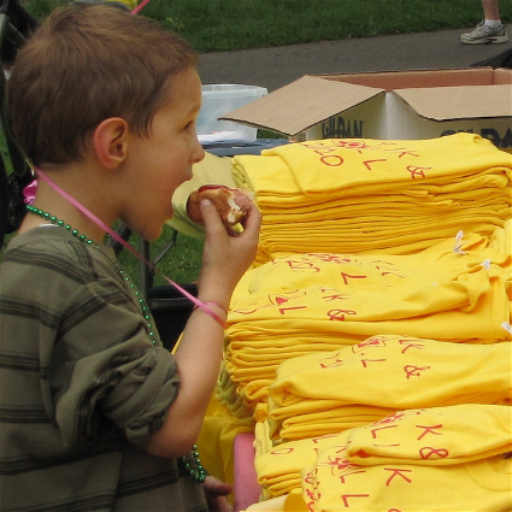

In [15]:
random.seed(449)

session_id = random.randint(1, 10)
trial_idx = random.randint(0, 749)

img_path = f"/content/nsd_bundle/sessions/subj01_session{session_id:02d}.pt"
images = torch.load(img_path, map_location="cpu", weights_only=False)
img_tensor = images[trial_idx]
img_normalized = (img_tensor + 1) / 2
img_pil = to_pil_image(img_normalized)

beta_path = f"/content/nsd_bundle/visualroi_betas/subj01_visualroi_session{session_id:02d}.pt"
betas = torch.load(beta_path, map_location="cpu", weights_only=False)
beta_vec = betas[trial_idx]

norm_stats = torch.load("beta_norm_stats.pt", map_location="cpu")
mean = norm_stats['mean']
std = norm_stats['std']
beta_vec = ((beta_vec - mean) / std).unsqueeze(0)  # [1, D] for model input

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beta_vec = beta_vec.to(DEVICE)

print(f"Session {session_id:02d}, Trial {trial_idx}, Beta shape: {beta_vec.shape}")
display(img_pil)

#### From test

SEED 4434  →  Session 10, Trial 102, Dataset idx 6852


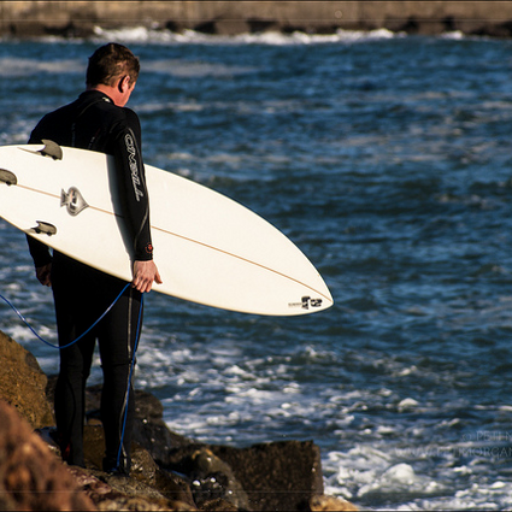

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 4434
rng  = random.Random(SEED)

x_batch, y_batch = next(iter(test_loader))
i = rng.randint(0, x_batch.size(0) - 1)

stats = torch.load("beta_norm_stats.pt")
mean, std = stats["mean"].to(DEVICE), stats["std"].to(DEVICE)

beta_vec = ((x_batch[i].to(DEVICE) - mean) / std).unsqueeze(0)

index_in_dataset = test_idx[i]
session_id = 1 + index_in_dataset // 750
trial_idx  = index_in_dataset % 750

img_path = f"/content/nsd_bundle/sessions/subj01_session{session_id:02d}.pt"
images = torch.load(img_path, map_location="cpu", weights_only=False)
img_pil  = to_pil_image((images[trial_idx] + 1) / 2)

print(f"SEED {SEED} ->  Session {session_id:02d}, Trial {trial_idx}, Dataset idx {index_in_dataset}")
display(img_pil)

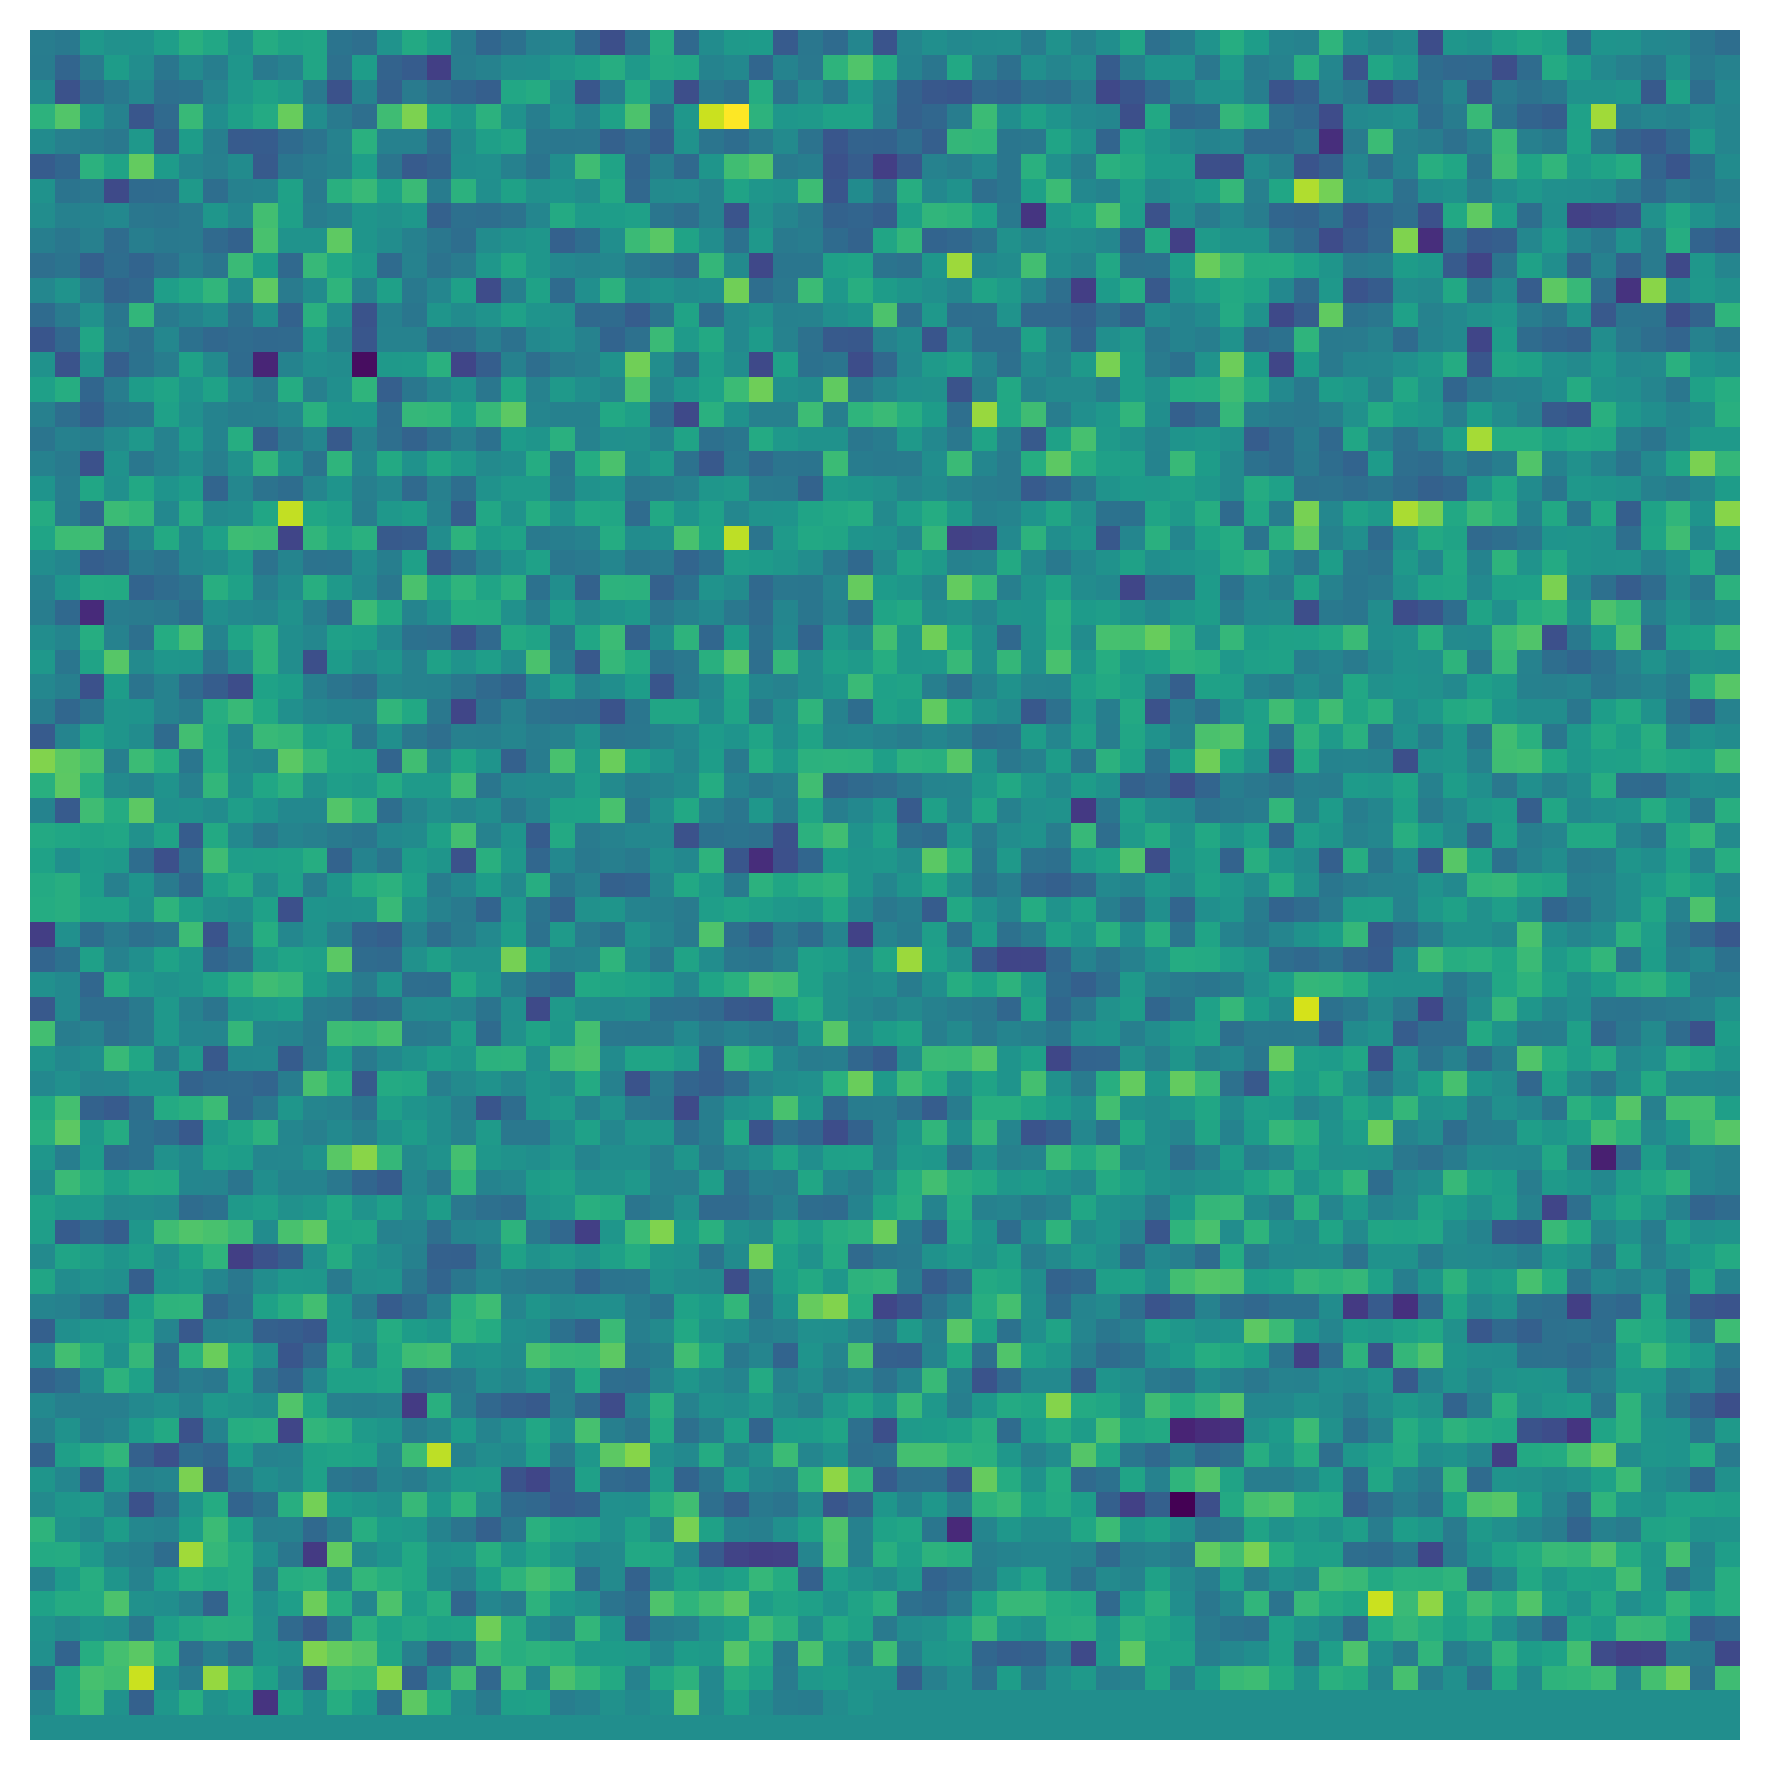

In [29]:
vec = beta_vec.cpu().numpy().flatten()
length = len(vec)

if length < 4:
    raise ValueError(f"Vector too short to visualize: length = {length}")

side = int(np.ceil(np.sqrt(length)))
padded = np.pad(vec, (0, side**2 - length), mode='constant')
reshaped = padded.reshape(side, side)

plt.figure(figsize=(6, 6), dpi=300)
sns.heatmap(reshaped, cmap="viridis", cbar=False)
plt.axis("off")
plt.tight_layout()
plt.show()

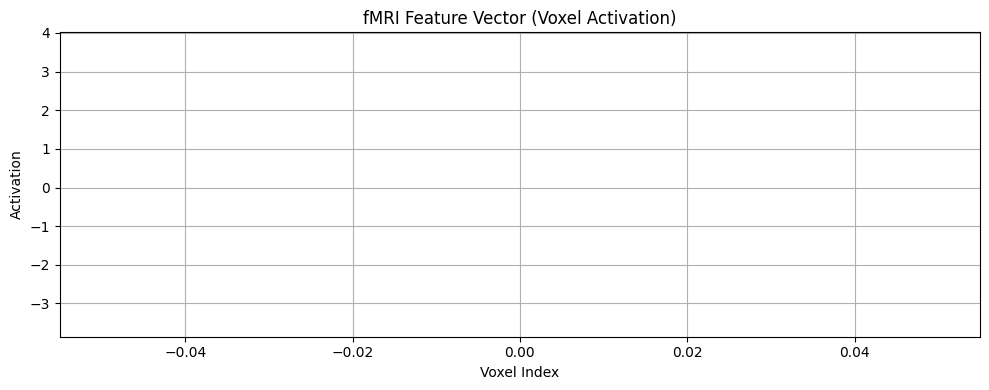

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(beta_vec.cpu().numpy())
plt.title("fMRI Feature Vector (Voxel Activation)")
plt.xlabel("Voxel Index")
plt.ylabel("Activation")
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing MLP

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

input_dim = dataset[0][0].shape[0]
model = FMRIEncoderMLP(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("/content/nsd_bundle/mlp.pth", map_location=device))
model.eval()

if not torch.is_tensor(beta_vec):
  raise ValueError("beta_vec is not a tensor.")
if beta_vec.ndim == 1:
  beta_input = beta_vec.unsqueeze(0).float().to(device)
else:
  beta_input = beta_vec.float().to(device)

with torch.no_grad():
  latent_pred = model(beta_input).squeeze(0)
  latent_pred = latent_pred * latent_std + latent_mean  # de-normalize
  latent_pred = latent_pred * 2 # normalized to -1 to 1
  latent_pred = latent_pred.view(1, 4, 64, 64).to(dtype)

# SDXL img to img pipeline
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
  "segmind/SSD-1B",
  torch_dtype=dtype,
  use_safetensors=True,
  variant="fp16" if dtype == torch.float16 else None
).to(device)

# denoising param
strength = 0.3
num_inference_steps = 20
pipe.scheduler.set_timesteps(num_inference_steps)
timesteps = pipe.scheduler.timesteps
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = timesteps[t_start:]

# noise
noise = torch.randn_like(latent_pred)
if timesteps.numel():
  timestep = timesteps[0:1].repeat(latent_pred.size(0))
  noisy_latent = pipe.scheduler.add_noise(latent_pred, noise, timestep)
else:
  noisy_latent = latent_pred

# dummy SDXL conditioning
B = latent_pred.size(0)
text_embeddings = torch.zeros(B, 77, 2048, dtype=dtype, device=device)
pooled_embeddings = torch.zeros(B, 1280, dtype=dtype, device=device)
time_ids = torch.tensor([[1024, 1024, 0, 0, 1024, 1024]] * B, dtype=dtype, device=device)

# denoise
latents = noisy_latent.clone()
with torch.no_grad():
  for t in timesteps:
    latent_input = pipe.scheduler.scale_model_input(latents, t)
    noise_pred = pipe.unet(
      latent_input, t,
      encoder_hidden_states=text_embeddings,
      added_cond_kwargs={
          "text_embeds": pooled_embeddings,
          "time_ids": time_ids
      },
      return_dict=False,
    )[0]
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

# decode latent to image
with torch.no_grad():
  decoded = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

image = (decoded / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).squeeze().numpy()
recon_pil = Image.fromarray((image * 255).astype(np.uint8))

print(f"Session {session_id:02d}, Trial {trial_idx}, Beta shape: {beta_vec.shape}")
display(recon_pil)
display(img_pil)

In [ ]:
print("Latent pred range:", latent_pred.min().item(), latent_pred.max().item())

### Testing Conv1D

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

input_dim = dataset[0][0].shape[0]
model = FMRIEncoderCNN1D(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("/content/nsd_bundle/conv.pth", map_location=device))
model.eval()

if not torch.is_tensor(beta_vec):
  raise ValueError("beta_vec is not a tensor.")
if beta_vec.ndim == 1:
  beta_input = beta_vec.unsqueeze(0).float().to(device)
else:
  beta_input = beta_vec.float().to(device)

# beta_vec to latent
with torch.no_grad():
  latent_pred = model(beta_input).squeeze(0)
  latent_pred = latent_pred * latent_std + latent_mean  # de-normalize
  latent_pred = latent_pred * 2 # normalized to -1 to 1
  latent_pred = latent_pred.view(1, 4, 64, 64).to(dtype)

# img2img pipeline
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
  "segmind/SSD-1B",
  torch_dtype=dtype,
  use_safetensors=True,
  variant="fp16" if dtype == torch.float16 else None
).to(device)

# denoising param
strength = 0.3
num_inference_steps = 20
pipe.scheduler.set_timesteps(num_inference_steps)
timesteps = pipe.scheduler.timesteps
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = timesteps[t_start:]

# add noise
noise = torch.randn_like(latent_pred)
if timesteps.numel():
  timestep = timesteps[0:1].repeat(latent_pred.size(0))
  noisy_latent = pipe.scheduler.add_noise(latent_pred, noise, timestep)
else:
  noisy_latent = latent_pred

# dummy SDXL conditioning
B = latent_pred.size(0)
text_embeddings = torch.zeros(B, 77, 2048, dtype=dtype, device=device)
pooled_embeddings = torch.zeros(B, 1280, dtype=dtype, device=device)
time_ids = torch.tensor([[1024, 1024, 0, 0, 1024, 1024]] * B, dtype=dtype, device=device)

# denoising
latents = noisy_latent.clone()
with torch.no_grad():
  for t in timesteps:
    latent_input = pipe.scheduler.scale_model_input(latents, t)
    noise_pred = pipe.unet(
      latent_input, t,
      encoder_hidden_states=text_embeddings,
      added_cond_kwargs={
        "text_embeds": pooled_embeddings,
        "time_ids": time_ids
      },
      return_dict=False,
    )[0]
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

# decode image to latent
with torch.no_grad():
  decoded = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

image = (decoded / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).squeeze().numpy()
recon_pil = Image.fromarray((image * 255).astype(np.uint8))

print(f"Session {session_id:02d}, Trial {trial_idx}, Beta shape: {beta_vec.shape}")
display(recon_pil)
display(img_pil)

In [ ]:
flat_latent = latent_pred.flatten().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.hist(flat_latent, bins=100, color='steelblue', alpha=0.8)
plt.title("Distribution of latent_pred values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
true_latent = torch.load("/content/nsd_bundle/latents_subj01/subj01_latents01.pt")
plt.hist(true_latent.view(-1).cpu().numpy(), bins=100)

### Testing Transformer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# beta_vec to latent
beta_input = beta_vec.unsqueeze(0).float().to(device)  # [1, D]
with torch.no_grad():
  latent_pred = model(beta_input).view(1, 4, 64, 64).to(dtype)
  latent_pred = latent_pred * 2

# img2img SXDL pipeline
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
  "segmind/SSD-1B",
  torch_dtype=dtype,
  use_safetensors=True,
  variant="fp16" if dtype == torch.float16 else None
).to(device)

input_dim = dataset[0][0].shape[0]  # or hardcode if known, e.g., 4984
model = FMRITransformerEncoder(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("/content/nsd_bundle/transformer.pth"))
model.eval()

# denoising param
strength = 0.3
num_inference_steps = 20
pipe.scheduler.set_timesteps(num_inference_steps)
timesteps = pipe.scheduler.timesteps
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = timesteps[t_start:]

# add noise
noise = torch.randn_like(latent_pred)
if timesteps.numel():
  timestep = timesteps[0:1].repeat(latent_pred.size(0))
  noisy_latent = pipe.scheduler.add_noise(latent_pred, noise, timestep)
else:
  noisy_latent = latent_pred

# dummy text conditioning
B = 1
text_embeddings = torch.zeros(B, 77, 2048, dtype=dtype, device=device)
pooled_embeddings = torch.zeros(B, 1280, dtype=dtype, device=device)
time_ids = torch.tensor([[1024, 1024, 0, 0, 1024, 1024]], dtype=dtype, device=device)

# denoising
latents = noisy_latent.clone()
with torch.no_grad():
  for i, t in enumerate(timesteps):
    latent_input = pipe.scheduler.scale_model_input(latents, t)
    noise_pred = pipe.unet(
      latent_input, t,
      encoder_hidden_states=text_embeddings,
      added_cond_kwargs={
        "text_embeds": pooled_embeddings,
        "time_ids": time_ids
      },
      return_dict=False,
    )[0]
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

# decode latent to image
with torch.no_grad():
  decoded = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
image = (decoded / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).squeeze().numpy()
recon_pil = Image.fromarray((image * 255).astype(np.uint8))

from IPython.display import display
print(f"Session {session_id:02d}, Trial {trial_idx}, Beta shape: {beta_vec.shape}")
display(recon_pil)
display(img_pil)

In [ ]:
## Test on Never Seen Data